In [10]:
from cirq import Circuit, LineQubit, Simulator, plot_state_histogram
from cirq import CNOT, H, measure, X, Z
import matplotlib.pyplot as plt

In [11]:
def xor(q1: LineQubit, q2: LineQubit, output: LineQubit):
    yield CNOT(q1, output)
    yield CNOT(q2, output)

In [12]:
def sudoku_oracle(inputs: list[LineQubit], tmp: list[LineQubit], output: LineQubit):
    yield xor(inputs[0], inputs[1], tmp[0])
    yield xor(inputs[1], inputs[3], tmp[1])
    yield xor(inputs[0], inputs[2], tmp[2])
    yield xor(inputs[2], inputs[3], tmp[3])

    yield X.controlled(4)(*tmp, output)

    yield xor(inputs[0], inputs[1], tmp[0])
    yield xor(inputs[1], inputs[3], tmp[1])
    yield xor(inputs[0], inputs[2], tmp[2])
    yield xor(inputs[2], inputs[3], tmp[3])

In [13]:
def reflect_zero(inputs: list[LineQubit]):
    length = len(inputs)

    yield X.on_each(inputs)
    yield Z.controlled(length - 1)(*inputs[:length - 1], inputs[-1])
    yield X.on_each(inputs)

In [14]:
def grover_circuit():
    inputs = [LineQubit(i) for i in range(4)]
    tmp = [LineQubit(i+4) for i in range(4)]
    pkb = LineQubit(8)

    c = Circuit()

    c.append(H.on_each(*inputs))
    c.append([X(pkb), H(pkb)])

    for _ in range(2):
        c.append(sudoku_oracle(inputs, tmp, pkb))

        c.append(H.on_each(inputs))
        c.append(reflect_zero(inputs))
        c.append(H.on_each(inputs))

    c.append(measure(*inputs, key="result"))

    return c

In [15]:
c = grover_circuit()

print('Circuit:')
print(c)

Circuit:
              ┌──┐   ┌──┐   ┌──┐               ┌──┐   ┌──┐   ┌──┐                               ┌──┐   ┌──┐   ┌──┐               ┌──┐   ┌──┐   ┌──┐
0: ───H───@─────@──────────────────────────@─────@─────H──────X─────────────────@───X───H───@─────@──────────────────────────@─────@─────H──────X─────────────────@───X───H───M('result')───
          │     │                          │     │                              │           │     │                          │     │                              │           │
1: ───H───┼────@┼─────@────────────────────┼────@┼─────@──────H─────X───────────@───X───H───┼────@┼─────@────────────────────┼────@┼─────@──────H─────X───────────@───X───H───M─────────────
          │    ││     │                    │    ││     │                        │           │    ││     │                    │    ││     │                        │           │
2: ───H───┼────┼┼─────┼@──────@────────────┼────┼┼─────┼@──────@────H───X───────@───X───H───┼────┼┼─────┼@──────@

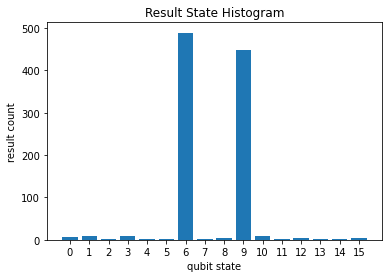

In [18]:
result = Simulator().run(c, repetitions=1000)
plot_state_histogram(result, plt.subplot())

plt.show()